Name: Myles Molnar <br>
Github Username: TheMyles <br>
USC ID: 7243135558

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import json
import cv2
from tensorflow.keras import layers, models

In [2]:
print(tf.__version__)  # Built with tf version 2.17.1

2.17.1


In [3]:
try:
  from google.colab import drive
  path_to_nb_dir = '/content/drive/'
  drive.mount(path_to_nb_dir, force_remount=True)
  os.chdir('drive/MyDrive/Colab_Notebooks/DSCI552/final-project-TheMyles/notebook')
  print('Mounted at', os.getcwd())
except:
  print('not mounted')

Mounted at /content/drive/
Mounted at /content/drive/MyDrive/Colab_Notebooks/DSCI552/final-project-TheMyles/notebook


In [4]:
path_to_train_data = '../data/seg_train'
path_to_test_data = '../data/seg_test'
os.listdir(path_to_train_data)

['mountain', 'street', 'sea', 'glacier', 'forest', 'buildings']

In [5]:
img_size = (160, 160)  # Most imgs I saw were 150x150, 160x160 to pad
batch_size = 5
n_classes = 6

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_train_data, shuffle=True, image_size=img_size, batch_size=batch_size)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_test_data, shuffle=True, image_size=img_size, batch_size=batch_size)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


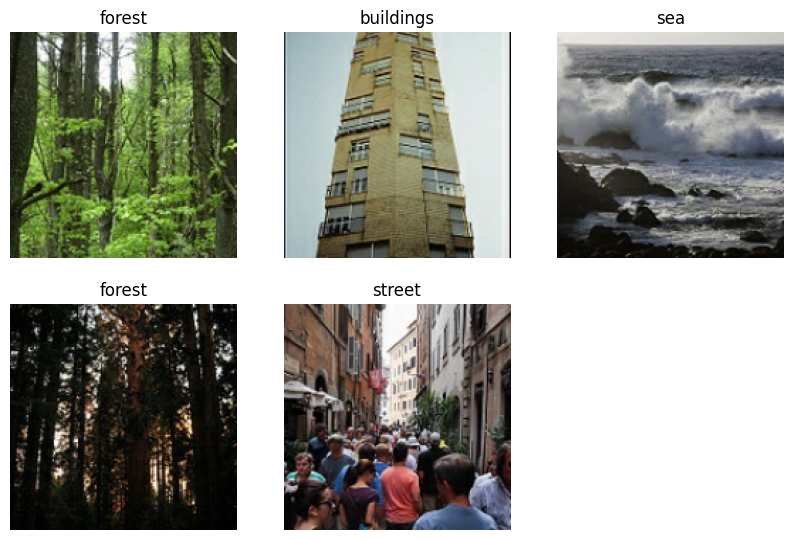

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(train_dataset)  # num batches = 2807
validation_dataset = train_dataset.take(val_batches // 5)  # 20% of train is validation
train_dataset = train_dataset.skip(val_batches // 5)

In [9]:
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=2807>

In [10]:
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of test batches: 600
Number of train batches: 2246
Number of validation batches: 561


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.Resizing(img_size[0], img_size[1]),  # Resize to normalize
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomCrop(img_size[0], img_size[1])
])

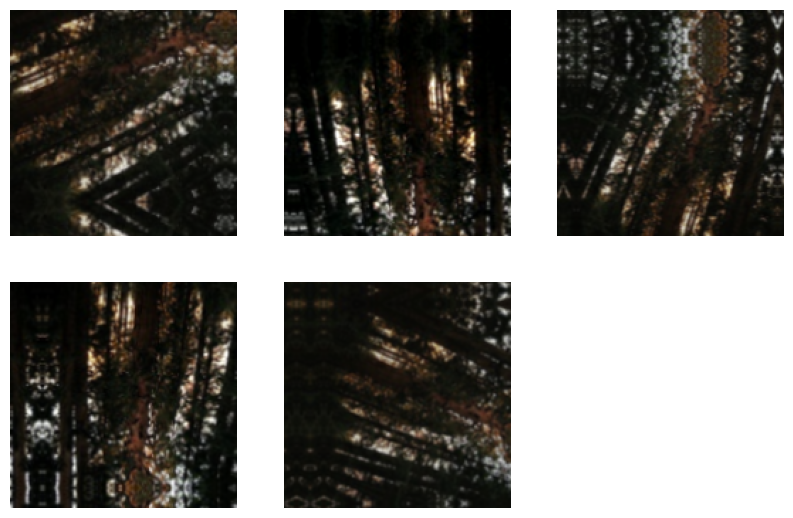

In [13]:
for image, _ in validation_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255.0)
    plt.axis('off')

In [14]:
modelBase_Res50 = tf.keras.applications.ResNet50(input_shape=img_size + (3, ),
                                            include_top=False,
                                            weights='imagenet')
modelBase_Res50.trainable = False

preprocess_Res50 = tf.keras.applications.resnet50.preprocess_input

In [15]:
image_batch, label_batch = next(iter(validation_dataset))
feature_batch = modelBase_Res50(image_batch)
print(feature_batch.shape)

(5, 5, 5, 2048)


In [16]:
## Adding layers: ReLU, softmax, L2, batch norm., ADAM
relu_dim = img_size[0] * img_size[1] // 32
layer_batchNorm = tf.keras.layers.BatchNormalization()  # Probably 1st after base & pooling
layer_relu_big = tf.keras.layers.Dense(relu_dim, activation='relu')  # High dimensional Relu layer = 800
layer_relu_med = tf.keras.layers.Dense(relu_dim//2, activation='relu')  # Med dimensional Relu layer = 400
layer_relu_sm = tf.keras.layers.Dense(relu_dim//8, activation='relu')  # Small dimensional Relu layer = 100
layer_softmax = tf.keras.layers.Dense(n_classes, activation='softmax')  # Last layer, 6 dims softmax
layer_dropout = tf.keras.layers.Dropout(0.2)

layer_pooling = tf.keras.layers.GlobalAveragePooling2D()  # From what I've read this is usually put very first


In [17]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_Res50(x)

# I chose this architecture to kind of "funnel" the base model into the softmax layer
x = modelBase_Res50(x, training=False)
x = layer_pooling(x)
x = layer_batchNorm(x)
x = layer_relu_big(x)
x = layer_dropout(x)
x = layer_relu_med(x)
x = layer_relu_sm(x)
outputs = layer_softmax(x)
model_Res50 = tf.keras.Model(inputs, outputs)


In [18]:
model_Res50.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 160, 160, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 160, 160)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 160, 160, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 160, 160, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 5, 5, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 800)            │      1,639,200 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 800)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 400)            │        320,400 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100)            │         40,100 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │            606 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,596,210 (97.64 MB)

 Trainable params: 2,004,402 (7.65 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

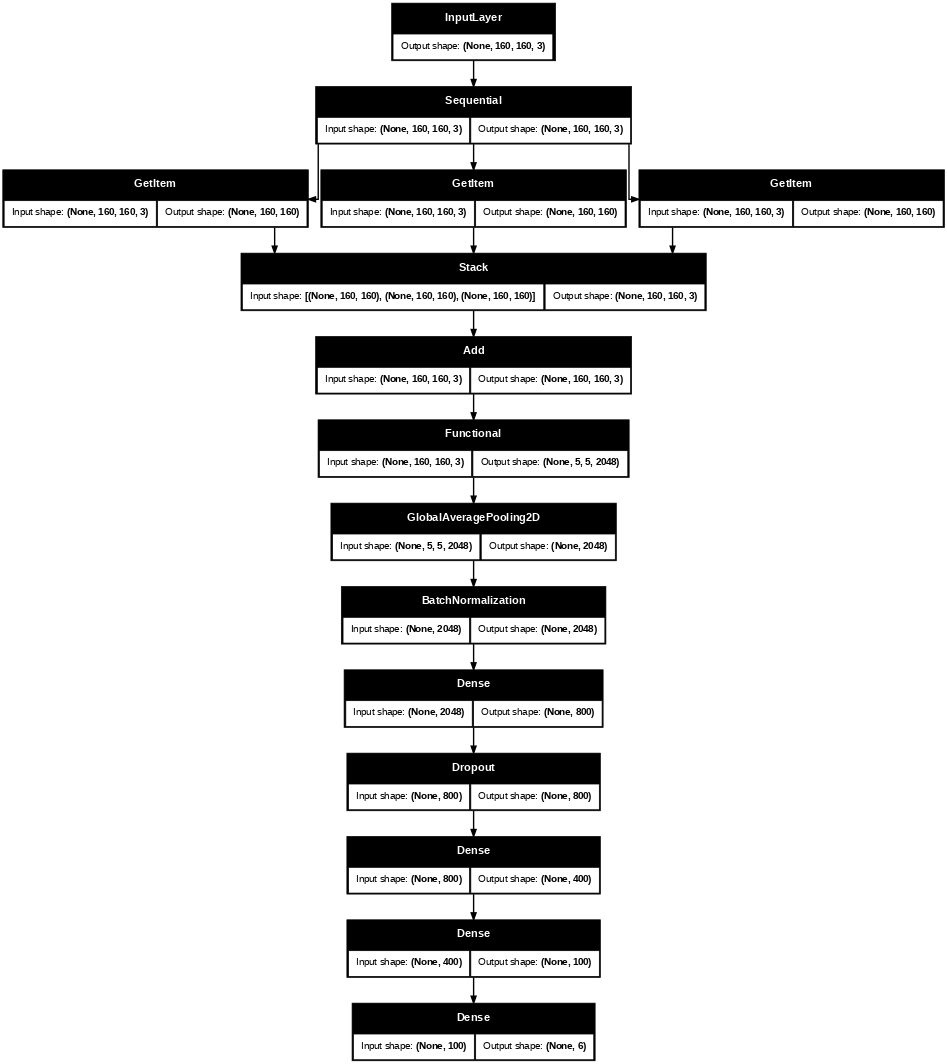

In [19]:
tf.keras.utils.plot_model(model_Res50, show_shapes=True, dpi=50)

In [20]:
# defining metrics
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(),
      tf.keras.metrics.CategoricalAccuracy(),
      tf.keras.metrics.F1Score(),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [21]:
base_learning_rate = 0.0001

optimizer_adam_l2 = tf.keras.optimizers.AdamW(learning_rate=base_learning_rate, weight_decay=0.0001)  # This is ADAM optimizer with L2 regularization

model_Res50.compile(optimizer=optimizer_adam_l2,
              loss='categorical_crossentropy',
              metrics=METRICS)

In [22]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

2246
561
600


In [23]:
def to_categorical(image, label):
  return image, tf.keras.utils.to_categorical(label, n_classes)

train_dataset = train_dataset.map(to_categorical)
validation_dataset = validation_dataset.map(to_categorical)
test_dataset = test_dataset.map(to_categorical)

In [24]:
validation_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [25]:
path_to_checkpoints = './model_checkpoints/'
os.makedirs(path_to_checkpoints, exist_ok=True)

checkpoints_res50 = path_to_checkpoints + 'res50_best.keras'

if os.path.exists(checkpoints_res50):
  model_Res50.load_weights(checkpoints_res50)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
n_epochs = 50  # First time training
n_epochs = 25  # Second time training

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=18)  # patience was 25 training0, 18 training1

checkpoint_callback_res50 = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoints_res50, save_weights_only=False, verbose=0)

csv_callback_res50 = [tf.keras.callbacks.CSVLogger(path_to_checkpoints + 'res50.log')]

# Training0 took ~30 mins, 32 epochs, 92.3% val acc
# Training1 took ~17 mins, 19 epochs, 90.7% val acc

# history_res50 = model_Res50.fit(train_dataset,
#             epochs=n_epochs,
#             validation_data=validation_dataset,
#             callbacks=[checkpoint_callback_res50, csv_callback_res50, early_stopping_callback])


In [27]:
hist = pd.read_csv(path_to_checkpoints + 'res50_1.log')
hist.tail(1)

,epoch,auc,categorical_accuracy,categorical_crossentropy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_categorical_crossentropy,val_f1_score,val_loss,val_precision,val_recall
18,18,0.987749,0.875323,0.330269,"""[tf.Tensor(0.87535405, shape=(), dtype=float3...",0.330269,0.888685,0.860985,0.989288,0.906952,0.302787,"""[tf.Tensor(0.90932304, shape=(), dtype=float3...",0.302787,0.909774,0.905882


In [28]:
modelBase_Res101 = tf.keras.applications.ResNet101(input_shape=img_size + (3, ),
                                            include_top=False,
                                            weights='imagenet')
modelBase_Res101.trainable = False

preprocess_Res101 = tf.keras.applications.resnet.preprocess_input

In [29]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_Res101(x)

x = modelBase_Res101(x, training=False)
x = layer_pooling(x)
x = layer_batchNorm(x)
x = layer_relu_big(x)
x = layer_dropout(x)
x = layer_relu_med(x)
x = layer_relu_sm(x)
outputs = layer_softmax(x)
model_Res101 = tf.keras.Model(inputs, outputs)

optimizer_adam_l2 = tf.keras.optimizers.AdamW(learning_rate=base_learning_rate, weight_decay=0.0001)  # This is ADAM optimizer with L2 regularization

model_Res101.compile(optimizer=optimizer_adam_l2,
              loss='categorical_crossentropy',
              metrics=METRICS)

In [30]:
model_Res101.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 160, 160, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 160, 160, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 160, 160, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 5, 5, 2048)     │     42,658,176 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 800)            │      1,639,200 │ batch_normalization[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 800)            │              0 │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 400)            │        320,400 │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100)            │         40,100 │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │            606 │ dense_2[1][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,666,674 (170.39 MB)

 Trainable params: 2,004,402 (7.65 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [31]:
checkpoints_res101 = path_to_checkpoints + 'res101_best.keras'

if os.path.exists(checkpoints_res101):
  model_Res101.load_weights(checkpoints_res101)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11)  # patience was 25 training0, 11 training1

checkpoint_callback_res101 = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoints_res101, save_weights_only=False, verbose=0)

csv_callback_res101 = [tf.keras.callbacks.CSVLogger(path_to_checkpoints + 'res101.log')]

# Training0 took ~48 mins, 39 epochs, 91.4% val acc
# Training1 took ~16 mins, 13 epochs, 90.7% val acc

# history_res101 = model_Res101.fit(train_dataset,
#             epochs=n_epochs,
#             validation_data=validation_dataset,
#             callbacks=[early_stopping_callback, csv_callback_res101, checkpoint_callback_res101])

In [33]:
pd.read_csv(path_to_checkpoints + 'res101_1.log').tail(1)

,epoch,auc,categorical_accuracy,categorical_crossentropy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_categorical_crossentropy,val_f1_score,val_loss,val_precision,val_recall
12,12,0.987724,0.874165,0.329253,"""[tf.Tensor(0.870886, shape=(), dtype=float32)...",0.329253,0.887465,0.863122,0.989685,0.903743,0.29367,"""[tf.Tensor(0.931472, shape=(), dtype=float32)...",0.29367,0.905937,0.90303


In [34]:
modelBase_EfficientNetB0 = tf.keras.applications.EfficientNetB0(input_shape=img_size + (3, ),
                                            include_top=False,
                                            weights='imagenet')
modelBase_EfficientNetB0.trainable = False

preprocess_EfficientNetB0 = tf.keras.applications.efficientnet.preprocess_input

In [35]:
# Have to re-initialize the layers to fit the architecture
layer_batchNorm = tf.keras.layers.BatchNormalization()
layer_relu_big = tf.keras.layers.Dense(relu_dim, activation='relu')  # High dimensional Relu layer = 800
layer_relu_med = tf.keras.layers.Dense(relu_dim//2, activation='relu')  # Med dimensional Relu layer = 400
layer_relu_sm = tf.keras.layers.Dense(relu_dim//8, activation='relu')  # Small dimensional Relu layer = 100
layer_softmax = tf.keras.layers.Dense(n_classes, activation='softmax')  # Last layer, 6 dims softmax
layer_dropout = tf.keras.layers.Dropout(0.2)

layer_pooling = tf.keras.layers.GlobalAveragePooling2D()  # From what I've read this is usually put very first

In [36]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_EfficientNetB0(x)

x = modelBase_EfficientNetB0(x, training=False)
x = layer_pooling(x)
x = layer_batchNorm(x)
x = layer_relu_big(x)
x = layer_dropout(x)
x = layer_relu_med(x)
x = layer_relu_sm(x)
outputs = layer_softmax(x)
model_EfficientNetB0 = tf.keras.Model(inputs, outputs)

optimizer_adam_l2 = tf.keras.optimizers.AdamW(learning_rate=base_learning_rate, weight_decay=0.0001)  # This is ADAM optimizer with L2 regularization

model_EfficientNetB0.compile(optimizer=optimizer_adam_l2,
              loss='categorical_crossentropy',
              metrics=METRICS)

In [37]:
model_EfficientNetB0.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 5, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 800)                 │       1,024,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 400)                 │         320,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,440,597 (20.75 MB)

 Trainable params: 1,388,466 (5.30 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [38]:
checkpoints_EfficientNetB0 = path_to_checkpoints + 'EfficientNetB0_best.keras'

if os.path.exists(checkpoints_EfficientNetB0):
  model_EfficientNetB0.load_weights(checkpoints_EfficientNetB0)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)  # patience was 25 training0, 6 training1

checkpoint_callback_EffNet = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoints_EfficientNetB0, save_weights_only=False, verbose=0)

csv_callback_EffNet = [tf.keras.callbacks.CSVLogger(path_to_checkpoints + 'EffNetB0.log')]

# Training0 took ~40 mins, 44 epochs, 89.5% val acc
# Training1 took ~11 mins, 13 epochs, 91.1% val acc

# history_EfficientNetB0 = model_EfficientNetB0.fit(train_dataset,
#             epochs=n_epochs,
#             validation_data=validation_dataset,
#             callbacks=[checkpoint_callback_EffNet, csv_callback_EffNet, early_stopping_callback])

In [40]:
pd.read_csv(path_to_checkpoints + 'EffNetB0_1.log').tail(1)

,epoch,auc,categorical_accuracy,categorical_crossentropy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_categorical_crossentropy,val_f1_score,val_loss,val_precision,val_recall
12,12,0.983551,0.855998,0.384448,"""[tf.Tensor(0.8717353, shape=(), dtype=float32...",0.384448,0.873546,0.836049,0.992974,0.91123,0.231432,"""[tf.Tensor(0.92773885, shape=(), dtype=float3...",0.231432,0.914275,0.908734


In [41]:
modelBase_VGG = tf.keras.applications.VGG16(input_shape=img_size + (3, ),
                                            include_top=False,
                                            weights='imagenet')
modelBase_VGG.trainable = False

preprocess_VGG = tf.keras.applications.vgg16.preprocess_input

In [42]:
# Have to re-initialize the layers to fit the architecture
layer_batchNorm = tf.keras.layers.BatchNormalization()
layer_relu_big = tf.keras.layers.Dense(relu_dim, activation='relu')  # High dimensional Relu layer = 800
layer_relu_med = tf.keras.layers.Dense(relu_dim//2, activation='relu')  # Med dimensional Relu layer = 400
layer_relu_sm = tf.keras.layers.Dense(relu_dim//8, activation='relu')  # Small dimensional Relu layer = 100
layer_softmax = tf.keras.layers.Dense(n_classes, activation='softmax')  # Last layer, 6 dims softmax
layer_dropout = tf.keras.layers.Dropout(0.2)

layer_pooling = tf.keras.layers.GlobalAveragePooling2D()  # From what I've read this is usually put very first

In [43]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_VGG(x)

x = modelBase_VGG(x, training=False)
x = layer_pooling(x)
x = layer_batchNorm(x)
x = layer_relu_big(x)
x = layer_dropout(x)
x = layer_relu_med(x)
x = layer_relu_sm(x)
outputs = layer_softmax(x)
model_VGG = tf.keras.Model(inputs, outputs)

optimizer_adam_l2 = tf.keras.optimizers.AdamW(learning_rate=base_learning_rate, weight_decay=0.0001)  # This is ADAM optimizer with L2 regularization

model_VGG.compile(optimizer=optimizer_adam_l2,
              loss='categorical_crossentropy',
              metrics=METRICS)

In [44]:
model_VGG.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 160, 160, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 160, 160)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 160, 160, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 160, 160, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 800)            │        410,400 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 800)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 400)            │        320,400 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 100)            │         40,100 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 6)              │            606 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,488,242 (59.08 MB)

 Trainable params: 772,530 (2.95 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [45]:
checkpoints_VGG = path_to_checkpoints + 'VGG_best.keras'

if os.path.exists(checkpoints_VGG):
  model_VGG.load_weights(checkpoints_VGG)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # patience was 25 training0, 10 training1

checkpoint_callback_VGG = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoints_VGG, save_weights_only=False, verbose=0)

csv_callback_VGG = [tf.keras.callbacks.CSVLogger(path_to_checkpoints + 'VGG.log')]

# Training0 took ~27 mins, 50 epochs, 89.7% val acc
# Training1 took ~6.5 mins, 12 epochs, 90.15 val acc

# history_VGG = model_VGG.fit(train_dataset,
#             epochs=n_epochs,
#             validation_data=validation_dataset,
#             callbacks=[csv_callback_VGG, checkpoint_callback_VGG, early_stopping_callback])

In [47]:
pd.read_csv(path_to_checkpoints + 'VGG_1.log').tail(1)  # Most current metrics

,epoch,auc,categorical_accuracy,categorical_crossentropy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_categorical_crossentropy,val_f1_score,val_loss,val_precision,val_recall
11,11,0.977897,0.828391,0.451889,"""[tf.Tensor(0.84066236, shape=(), dtype=float3...",0.451889,0.853624,0.802387,0.987398,0.900891,0.330743,"""[tf.Tensor(0.89153755, shape=(), dtype=float3...",0.330743,0.903122,0.897326


## Metrics

Text(0.5, 0, 'Epochs')

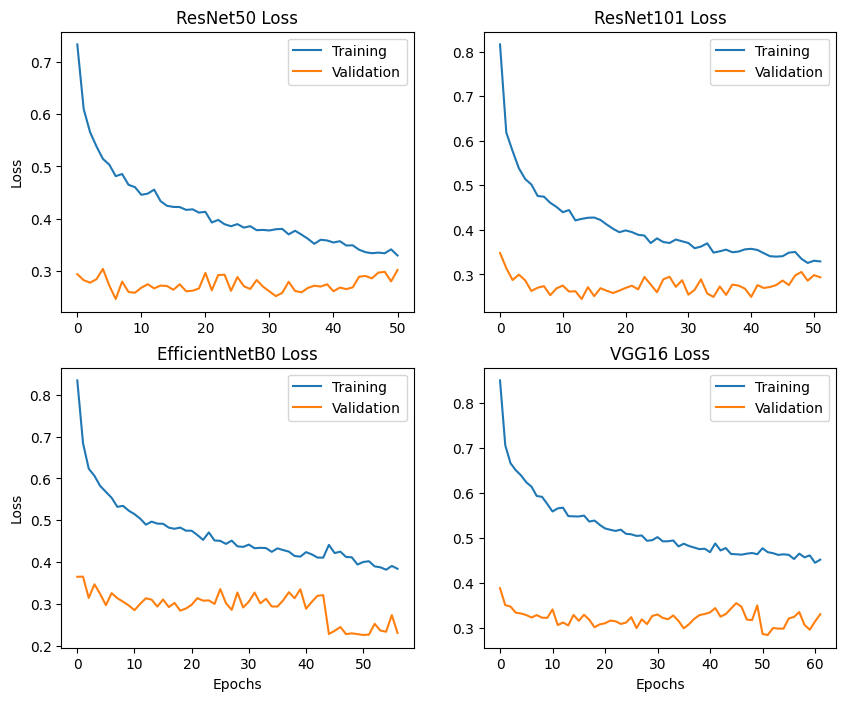

In [48]:
# Starting with training & validation loss vs epochs
# logs are stored in 2 files per model
hist_res50 = pd.read_csv(path_to_checkpoints + 'res50_0.log')
hist_res50 = pd.concat([hist_res50, pd.read_csv(path_to_checkpoints + 'res50_1.log')], ignore_index=True)

hist_res101 = pd.read_csv(path_to_checkpoints + 'res101_0.log')
hist_res101 = pd.concat([hist_res101, pd.read_csv(path_to_checkpoints + 'res101_1.log')], ignore_index=True)

hist_EfficientNetB0 = pd.read_csv(path_to_checkpoints + 'EffNetB0_0.log')
hist_EfficientNetB0 = pd.concat([hist_EfficientNetB0, pd.read_csv(path_to_checkpoints + 'EffNetB0_1.log')], ignore_index=True)

hist_VGG = pd.read_csv(path_to_checkpoints + 'VGG_0.log')
hist_VGG = pd.concat([hist_VGG, pd.read_csv(path_to_checkpoints + 'VGG_1.log')], ignore_index=True)

fig, ax = plt.subplots(2, 2, figsize=[10, 8])

ax[0, 0].plot(hist_res50['loss'], label='Training')
ax[0, 0].plot(hist_res50['val_loss'], label='Validation')
ax[0, 0].legend()
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_title('ResNet50 Loss')

ax[0, 1].plot(hist_res101['loss'], label='Training')
ax[0, 1].plot(hist_res101['val_loss'], label='Validation')
ax[0, 1].legend()
ax[0, 1].set_title('ResNet101 Loss')

ax[1, 0].plot(hist_EfficientNetB0['loss'], label='Training')
ax[1, 0].plot(hist_EfficientNetB0['val_loss'], label='Validation')
ax[1, 0].legend()
ax[1, 0].set_title('EfficientNetB0 Loss')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Loss')

ax[1, 1].plot(hist_VGG['loss'], label='Training')
ax[1, 1].plot(hist_VGG['val_loss'], label='Validation')
ax[1, 1].legend()
ax[1, 1].set_title('VGG16 Loss')
ax[1, 1].set_xlabel('Epochs')

Text(0.5, 0, 'Epochs')

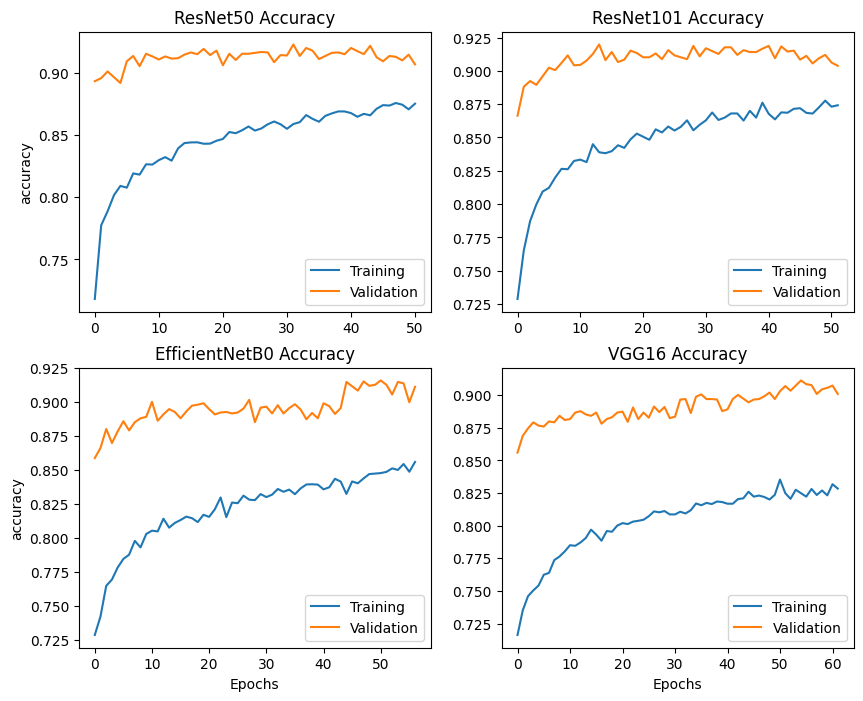

In [49]:
# Training & validation accuracies vs epochs
fig, ax = plt.subplots(2, 2, figsize=[10, 8])

ax[0, 0].plot(hist_res50['categorical_accuracy'], label='Training')
ax[0, 0].plot(hist_res50['val_categorical_accuracy'], label='Validation')
ax[0, 0].legend()
ax[0, 0].set_ylabel('accuracy')
ax[0, 0].set_title('ResNet50 Accuracy')

ax[0, 1].plot(hist_res101['categorical_accuracy'], label='Training')
ax[0, 1].plot(hist_res101['val_categorical_accuracy'], label='Validation')
ax[0, 1].legend()
ax[0, 1].set_title('ResNet101 Accuracy')

ax[1, 0].plot(hist_EfficientNetB0['categorical_accuracy'], label='Training')
ax[1, 0].plot(hist_EfficientNetB0['val_categorical_accuracy'], label='Validation')
ax[1, 0].legend()
ax[1, 0].set_title('EfficientNetB0 Accuracy')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('accuracy')

ax[1, 1].plot(hist_VGG['categorical_accuracy'], label='Training')
ax[1, 1].plot(hist_VGG['val_categorical_accuracy'], label='Validation')
ax[1, 1].legend()
ax[1, 1].set_title('VGG16 Accuracy')
ax[1, 1].set_xlabel('Epochs')

In [50]:
# Getting models ready, shouldn't be necessary
# model_Res50.load_weights(checkpoints_res50)
# model_Res101.load_weights(checkpoints_res101)
# model_EfficientNetB0.load_weights(checkpoints_EfficientNetB0)
# model_VGG.load_weights(checkpoints_VGG)

In [51]:
# First getting the train, test, val metrics for all models
# ResNet50
print("ResNet50: train, test, val")
train_metrics = model_Res50.evaluate(train_dataset, batch_size=batch_size, return_dict=True).values()
test_metrics = model_Res50.evaluate(test_dataset, batch_size=batch_size, return_dict=True).values()
val_metrics = model_Res50.evaluate(validation_dataset, batch_size=batch_size, return_dict=True).values()

train_metrics = list(train_metrics)
test_metrics = list(test_metrics)
val_metrics = list(val_metrics)

test_metrics[3] = np.mean(test_metrics[3])  # test_metrics[3] is a numpy array of n_classes=6 numbers
train_metrics[3] = np.mean(train_metrics[3])
val_metrics[3] = np.mean(val_metrics[3])

metrics_res50 = pd.DataFrame(data={'train': train_metrics, 'validation': val_metrics,
                                   'test': test_metrics}, index=hist_res50.columns[1:len(test_metrics)+1])

print("ResNet101: train, test, val")
train_metrics = model_Res101.evaluate(train_dataset, batch_size=batch_size, return_dict=True).values()
test_metrics = model_Res101.evaluate(test_dataset, batch_size=batch_size, return_dict=True).values()
val_metrics = model_Res101.evaluate(validation_dataset, batch_size=batch_size, return_dict=True).values()

train_metrics = list(train_metrics)
test_metrics = list(test_metrics)
val_metrics = list(val_metrics)

test_metrics[3] = np.mean(test_metrics[3])
train_metrics[3] = np.mean(train_metrics[3])
val_metrics[3] = np.mean(val_metrics[3])

metrics_res101 = pd.DataFrame(data={'train': train_metrics, 'validation': val_metrics,
                                   'test': test_metrics}, index=hist_res101.columns[1:len(test_metrics)+1])

print("EffNet: train, test, val")
train_metrics = model_EfficientNetB0.evaluate(train_dataset, batch_size=batch_size, return_dict=True).values()
test_metrics = model_EfficientNetB0.evaluate(test_dataset, batch_size=batch_size, return_dict=True).values()
val_metrics = model_EfficientNetB0.evaluate(validation_dataset, batch_size=batch_size, return_dict=True).values()

train_metrics = list(train_metrics)
test_metrics = list(test_metrics)
val_metrics = list(val_metrics)

test_metrics[3] = np.mean(test_metrics[3])
train_metrics[3] = np.mean(train_metrics[3])
val_metrics[3] = np.mean(val_metrics[3])

metrics_EfficientNetB0 = pd.DataFrame(data={'train': train_metrics, 'validation': val_metrics,
                                            'test': test_metrics},
                                      index=hist_EfficientNetB0.columns[1:len(test_metrics)+1])

print("VGG16: train, test, val")
train_metrics = model_VGG.evaluate(train_dataset, batch_size=batch_size, return_dict=True).values()
test_metrics = model_VGG.evaluate(test_dataset, batch_size=batch_size, return_dict=True).values()
val_metrics = model_VGG.evaluate(validation_dataset, batch_size=batch_size, return_dict=True).values()

train_metrics = list(train_metrics)
test_metrics = list(test_metrics)
val_metrics = list(val_metrics)

test_metrics[3] = np.mean(test_metrics[3])
train_metrics[3] = np.mean(train_metrics[3])
val_metrics[3] = np.mean(val_metrics[3])

metrics_VGG = pd.DataFrame(data={'train': train_metrics, 'validation': val_metrics,
                                   'test': test_metrics}, index=hist_VGG.columns[1:len(test_metrics)+1])

ResNet50: train, test, val
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 450s 155ms/step - auc: 0.9374 - categorical_accuracy: 0.6933 - categorical_crossentropy: 0.8660 - f1_score: 0.6858 - loss: 0.8660 - precision: 0.7160 - recall: 0.6671
600/600 ━━━━━━━━━━━━━━━━━━━━ 190s 315ms/step - auc: 0.9382 - categorical_accuracy: 0.7009 - categorical_crossentropy: 0.8538 - f1_score: 0.6904 - loss: 0.8538 - precision: 0.7292 - recall: 0.6739
561/561 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - auc: 0.9403 - categorical_accuracy: 0.6985 - categorical_crossentropy: 0.8389 - f1_score: 0.6846 - loss: 0.8389 - precision: 0.7257 - recall: 0.6734
ResNet101: train, test, val
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - auc: 0.9757 - categorical_accuracy: 0.8288 - categorical_crossentropy: 0.4890 - f1_score: 0.8284 - loss: 0.2300 - precision: 0.8428 - recall: 0.8184
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - auc: 0.9919 - categorical_accuracy: 0.9175 - categorical_crossentropy: 0.2385 - f1_score: 0.9164 - loss: 0.2385 - pre

In [53]:
def retrieve_name(var):  # Used later, gets variable name
    import inspect
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [54]:
scores = [metrics_res50, metrics_res101, metrics_EfficientNetB0, metrics_VGG]

for score in scores:
  print('###', retrieve_name(score)[0])
  print(score)
  print('\n')

### metrics_res50
                             train  validation      test
auc                       0.936813    0.936043  0.933503
categorical_accuracy      0.694363    0.689127  0.688333
categorical_crossentropy  0.870199    0.883843  0.894287
f1_score                  0.685497    0.680021  0.683543
loss                      0.870199    0.883843  0.894287
precision                 0.721795    0.714724  0.714286
recall                    0.668893    0.664528  0.656667


### metrics_res101
                             train  validation      test
auc                       0.986169    0.992508  0.991447
categorical_accuracy      0.877512    0.918360  0.911333
categorical_crossentropy  0.350990    0.235433  0.248338
f1_score                  0.878007    0.919426  0.912835
loss                      0.217883    0.235433  0.248338
precision                 0.886089    0.920516  0.912158
recall                    0.871883    0.916578  0.910333


### metrics_EfficientNetB0
                    

### Conclusion

The model with the highest scores was ResNet101. This isn't surprising as this is the model with highest number of parameters and the one that took the longest to train.

They all did fairly well though except ResNet50.